### Required libraries 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import tensorflow as tf
import seaborn as sns

### Loading masks

In [2]:
data = pd.read_csv("D:/TestData/train_ship_segmentations_v2.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [4]:
data.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


In [5]:
data['ImageId'].value_counts()

e6fd0c12e.jpg    15
2053a78bd.jpg    15
d3c47b3d3.jpg    15
4de149bd9.jpg    15
c8e722430.jpg    15
                 ..
591ab2331.jpg     1
591af2fb2.jpg     1
591afc23d.jpg     1
591b2dd30.jpg     1
ffffe97f3.jpg     1
Name: ImageId, Length: 192556, dtype: int64

As we can see we have much more images without ships (NaN values in 'EncodedPixels' column) on it than images with ships, so we have to balance data. Also in dataframe there are multiple masks for one image so we need clean data from this masks.  

In [6]:
data.drop_duplicates(['ImageId'], inplace=True, keep=False)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177104 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        177104 non-null  object
 1   EncodedPixels  27104 non-null   object
dtypes: object(2)
memory usage: 4.1+ MB


In [8]:
def empt(x):
    if type(x) == float:
        return 0 
    else: return 1

data['Empty'] = data["EncodedPixels"].apply(lambda x : empt(x))

In [9]:
data.head()

,ImageId,EncodedPixels,Empty
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
8,0001b1832.jpg,NaN,0
20,0002d0f32.jpg,NaN,0


<Axes: xlabel='Empty', ylabel='count'>

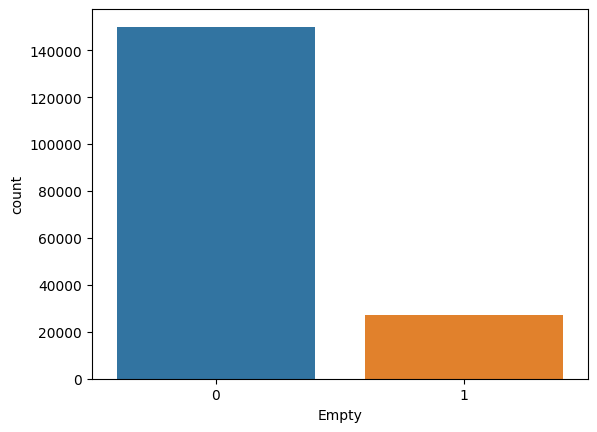

In [10]:
sns.countplot(data, x='Empty')

In [18]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
y = data['Empty']
X = data.drop('Empty',axis=1)
X,y = undersample.fit_resample(X,y)
data_balanced = pd.concat([pd.DataFrame(y),X],axis=1)
data=data_balanced

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54208 entries, 0 to 54207
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Empty          54208 non-null  int64 
 1   ImageId        54208 non-null  object
 2   EncodedPixels  27104 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


<Axes: xlabel='Empty', ylabel='count'>

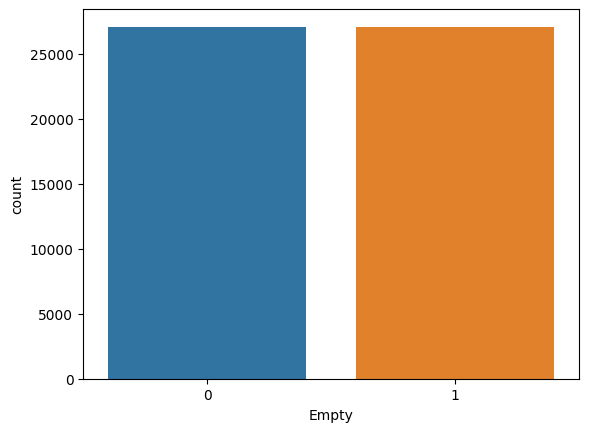

In [20]:
sns.countplot(data, x='Empty')

In [21]:
data['ImageId'].value_counts()

d4f0aaa70.jpg    1
55afceaa4.jpg    1
55751788c.jpg    1
55793bcea.jpg    1
55796ba40.jpg    1
                ..
e34547b59.jpg    1
c71158b74.jpg    1
a5e751e28.jpg    1
72d04c2bc.jpg    1
fffdd2377.jpg    1
Name: ImageId, Length: 54208, dtype: int64

### Creating training dataset

Now let`s create folders with images and masks from cleaned dataset  

In [6]:
def convert_masks(mask_id):
    target_string = data[data["ImageId"] == mask_id]['EncodedPixels'].values[0]
    if type(target_string) == float:
        return np.zeros((768,768), dtype=int)
    
    rle = list(map(int, target_string.split(' ')))
    pixel,pixel_count = [],[]
    [pixel.append(rle[i]) if i%2==0 else pixel_count.append(rle[i]) for i in range(0, len(rle))]
    rle_pixels = [list(range(pixel[i],pixel[i]+pixel_count[i])) for i in range(0, len(pixel))]
    rle_mask_pixels = sum(rle_pixels,[]) 
    rle_mask_pixels = [idx for idx in rle_mask_pixels if idx < 768*768]
    mask_img = np.zeros((768*768,1), dtype=int)
    mask_img[rle_mask_pixels] = 255
    mask = np.reshape(mask_img, (768, 768)).T
    return mask

In [42]:
fold = 'D:/TestData/masks/' # Replace with the path for the output directory
            
for i in data['ImageId']:
    array = convert_masks(i).astype(np.uint8)
    image = Image.fromarray(array)
    path = os.path.join(fold, i)
    image.save(path)

In [47]:
fold = 'D:/TestData/images/' # Replace with the path for the output directory
dir = 'D:/TestData/train_v2/' # Replace with the path for the original directory

for i in data['ImageId']:
    path = os.path.join(dir, i)
    image = Image.open(path)
    path = os.path.join(fold, i)
    image.save(path)